# Stroke Prediction Models

This dataset was taken from Kaggle which shows the patients who had a stroke, along with many other features like age and gender. I will process the data and create classification models to help predict stroke based on the features given

#### https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('healthcare_dataset_stroke_data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.groupby('gender')['stroke'].value_counts()

gender  stroke
Female  0         2853
        1          141
Male    0         2007
        1          108
Other   0            1
Name: stroke, dtype: int64

While checking the stroke disparity among genders I noticed one dataset that had an 'other' gender and I decided to drop it as it is just 1 row of data and creating an additional gender feature was not computationally worth it.

In [7]:
i_drop=  df[df['gender']=='Other'].index
df.drop(index=i_drop,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   Residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                4908 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 518.9+ KB


From the info, it can be seen that there are only 5109 rows which is very little. It will be quite hard to form a good model given the small dataset but we will try nonetheless.

In [8]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,36513.985516,43.229986,0.097475,0.054022,106.140399,28.89456,0.048738
std,21162.008804,22.613575,0.296633,0.226084,45.285004,7.85432,0.215340
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


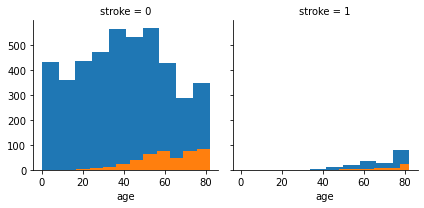

In [38]:
g = sns.FacetGrid(df,col = 'stroke' , hue = 'hypertension')
g.map(plt.hist, 'age')

Those who had a stroke tend to be of a higher age

<AxesSubplot:xlabel='ever_married', ylabel='count'>

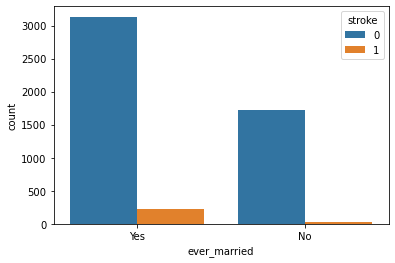

In [44]:
sns.countplot( x =df['ever_married'],hue = df['stroke'])

<AxesSubplot:xlabel='heart_disease', ylabel='count'>

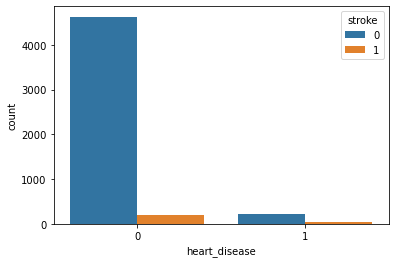

In [45]:
sns.countplot( x =df['heart_disease'],hue = df['stroke'])

<AxesSubplot:xlabel='bmi', ylabel='Count'>

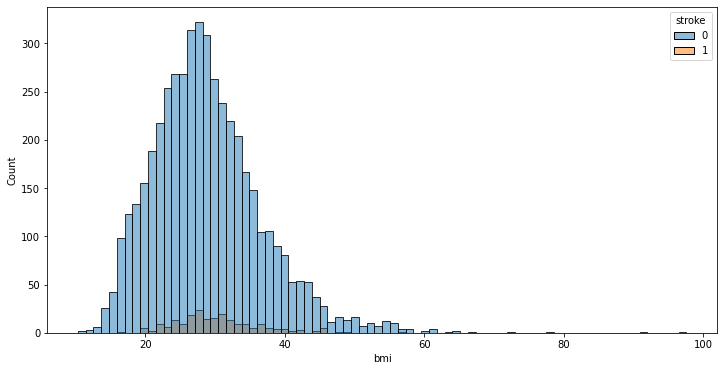

In [51]:
plt.figure(figsize=(12,6))
sns.histplot(x= df['bmi'],hue=df['stroke'])

Slight skew where those who had a stroke tended to have a greater BMI.

### To check the amount of NA data

<AxesSubplot:>

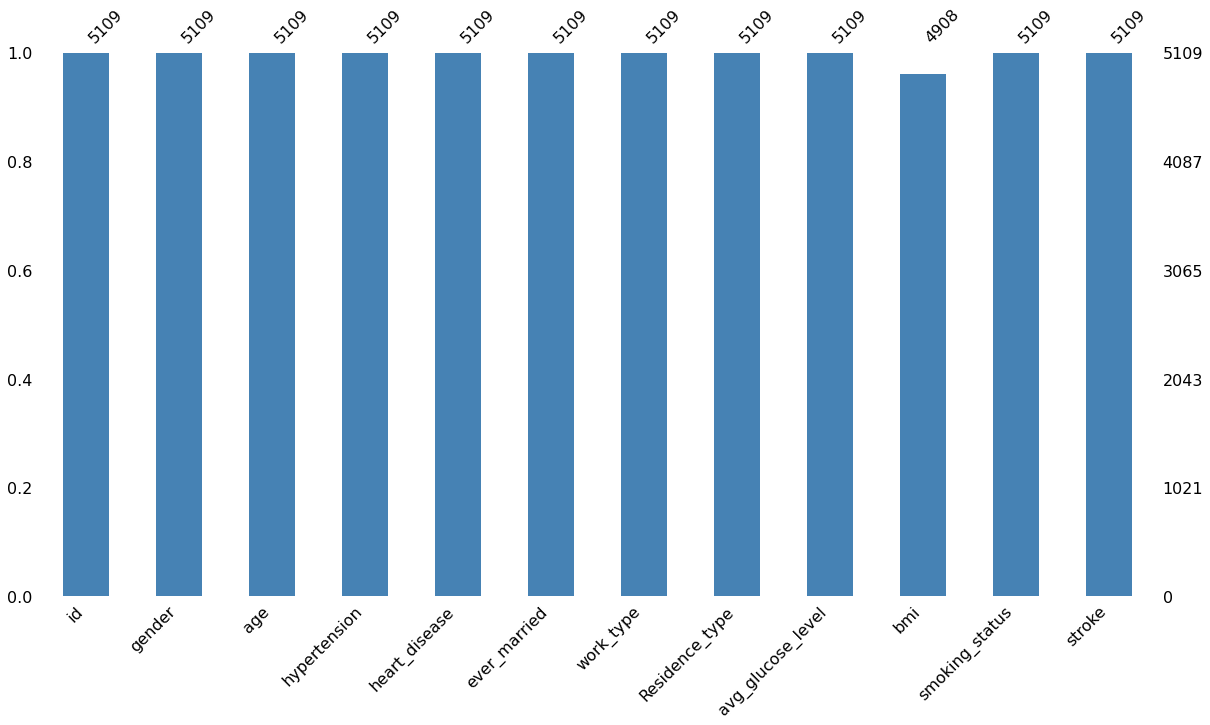

In [9]:
import missingno as msno
msno.bar(df, figsize=(20,10),color='steelblue')

In [10]:
df[df['bmi'].isna()]['stroke'].value_counts()

0    161
1     40
Name: stroke, dtype: int64

###### Only BMI had missing values, now we check if those with NA BMI had any significantly different 'stroke' category

In [11]:
Percen_strokeNA = df[df['bmi'].isna()]['stroke'].value_counts()[1]/df[df['bmi'].isna()]['stroke'].value_counts().sum() *100
Percen_strokeNA

19.900497512437813

In [12]:
non_na= df[df['bmi'].notna()]['stroke'].value_counts()
Percen_stroke = non_na[1]/(non_na.sum()) *100
Percen_stroke

4.258353708231459

The datasets with NA BMI had a 20% stroke rate, while the completed datasets had a 4% stroke rate. The stroke rate was 5 times more than the completed data and that is very signigicant. Hence, we have to handle the NA values very carefully and using mean or mode will not be a good method to impute the missing values.

###### After talking to a student studying medicine, gender, age and acg glucose level were chosen to be the most influential factors to BMI. Hence we will use these 3 factors to perform linear regression and pedict the missing BMI NA values. We will proceed to perform linear regression to estimate the missing values of BMI using  the columns of age, gender and avg_glucose_level.

In [13]:
data_na = df[df['bmi'].isna()]
data_na

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [14]:
data = df[df['bmi'].notna()]
data.shape

(4908, 12)

In [15]:

data_cat = pd.get_dummies(data['gender'],drop_first=True)
X = data.join(data_cat,how='right')
X = X[['Male','age','avg_glucose_level']]
y = data['bmi']

In [16]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

In [17]:
data_na.drop('bmi',axis=1,inplace=True)

C:\Users\kchun\Anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
data_na_cat = pd.get_dummies(data_na['gender'],drop_first=True)
data_na = data_na.join(data_na_cat,how='right')


In [19]:
data_na['bmi'] = lm.predict(data_na[['Male','age','avg_glucose_level']])
data_na['bmi'].describe()

count    201.000000
mean      30.235439
std        2.815137
min       23.542286
25%       28.035210
50%       31.018322
75%       32.258005
max       35.397183
Name: bmi, dtype: float64

In [20]:
final_data=pd.concat([data,data_na])

In [21]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5105
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   Residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                5109 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int64  
 12  Male               201 non-null    float64
dtypes: float64(4), int64(4), object(5)
memory usage: 558.8+ KB


There are no longer any NA values, we will now proceed to preprocess the data for model training.

###### Now we need to drop the Male column and encode gender,ever_married,work_type,residence type and smoking status so that our categorical features are numerical for our model to train

In [22]:
final_data['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [23]:
clean_cat = pd.get_dummies(final_data[['gender','ever_married','work_type','Residence_type','smoking_status']])
final_data_cleaned=final_data.join(clean_cat,how='right')
final_data_cleaned.drop(['id','Male','gender','ever_married','work_type','Residence_type','smoking_status'],axis=1,inplace=True)

In [24]:
final_data_cleaned.drop(['gender_Female','ever_married_No','Residence_type_Rural'],axis=1,inplace=True)

I dropped the gender female, not married and residence type rual as they are just direct opposites of the similar categorical feature and will not give us more information.

In [25]:
final_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5105
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   gender_Male                     5109 non-null   uint8  
 7   ever_married_Yes                5109 non-null   uint8  
 8   work_type_Govt_job              5109 non-null   uint8  
 9   work_type_Never_worked          5109 non-null   uint8  
 10  work_type_Private               5109 non-null   uint8  
 11  work_type_Self-employed         5109 non-null   uint8  
 12  work_type_children              51

In [26]:
final_data_cleaned['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

The data set is small and the class 1 is extremely small also. The data is highly imbalanced and hence our models need to account for it.

## Model Building - Weighted Logistic Regression

Weighted logistic regression will invove assigning different weights to the class 1 and 0 for stroke and we will use GridSearchCV to find the optimal weights

###### Train Test Split with stratify as there might be a chance that our test data will have 0 class 1, hence we use stratify to ensure that does'nt occur.

In [27]:
from sklearn.model_selection import train_test_split
X = final_data_cleaned.drop('stroke',axis=1)
y = final_data_cleaned['stroke']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101,stratify=y)

We will use a pipeline to help us scale and gridsearch for the best parameter that gives the best AUC-ROC value. AUC-ROC is the area under the curve for the receiver operator characteristic where it measures the ability of binary classification regardless of sample imabalance. We adjust the class weight to find the optimal one and apply it to our model.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe_steps = [('Scaler',StandardScaler()),('Lg',LogisticRegression(random_state=101))]
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(1, 20.0, 0.5)
params = {'Lg__C':crange, 'Lg__class_weight':w, 'Lg__fit_intercept': [True, False]}
pipeline1  = Pipeline(pipe_steps)

###### We will perform a 4 fold and 5 fold Cross Validation gridsearch and the tqdm library will help us track with a progress bar

In [29]:
from tqdm import tqdm

print('Start Fitting Training Data')
for cv in tqdm(range(4,6)):
    lg_grid = GridSearchCV(pipeline1,param_grid=params,cv=cv,scoring='roc_auc',n_jobs=-1)
    lg_grid.fit(X_train,y_train)
    print('score for %d fold CV:= %3.2f' %(cv,lg_grid.score(X_test,y_test)))
    print('Best fit parameters from Training Data')
    print(lg_grid.best_params_)
print('done')

  0%|          | 0/2 [00:00<?, ?it/s]

Start Fitting Training Data


 50%|█████     | 1/2 [00:28<00:28, 28.21s/it]

score for 4 fold CV:= 0.86
Best fit parameters from Training Data
{'Lg__C': 1.0, 'Lg__class_weight': {0: 1.0, 1: 10}, 'Lg__fit_intercept': False}


100%|██████████| 2/2 [01:02<00:00, 31.08s/it]

score for 5 fold CV:= 0.86
Best fit parameters from Training Data
{'Lg__C': 1.0, 'Lg__class_weight': {0: 1.0, 1: 10}, 'Lg__fit_intercept': False}
done


Optimal Weight was found to be {0: 1.0, 1: 10}

No Skill: ROC AUC=0.500
LogisticRegression: ROC AUC=0.855


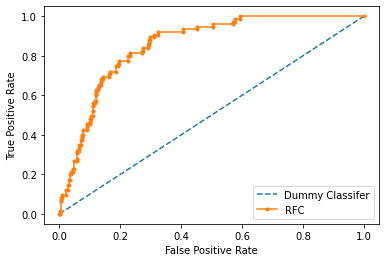

In [30]:


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lg_grid.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RFC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


Above is the graph of the ROC cruve which has the True Positive Rate vs the False Positive Rate. 

###### This model has a AUC-ROC score of 84.5%, perhaps oversampling might be better, hence we will now try oversampling

In [31]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
from collections import Counter

print("Before {}".format(Counter(y_train)))
print("After {}".format(Counter(y_train_res)))


Before Counter({0: 3402, 1: 174})
After Counter({0: 3402, 1: 3402})


The training data set now has equal class for stroke. Now we will scale our data.

In [32]:
scale = StandardScaler()
scale.fit(X_train_res)
X_train_res_s = scale.transform(X_train_res)
X_test_s = scale.transform(X_test)

## Model Building - Logistic Regression with oversampling

In [33]:
log = LogisticRegression(random_state=101)
log.fit(X_train_res_s,y_train_res)

LogisticRegression(random_state=101)

In [34]:
predl = log.predict(X_test_s)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(confusion_matrix(y_test,predl))
print('\n')
print(classification_report(y_test,predl))
print('\n')
print('Accuracy score {:.2f}'.format(accuracy_score(y_test,predl)*100))

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = log.predict_proba(X_test_s)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

[[1408   50]
 [  65   10]]


              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1458
           1       0.17      0.13      0.15        75

    accuracy                           0.92      1533
   macro avg       0.56      0.55      0.55      1533
weighted avg       0.92      0.92      0.92      1533



Accuracy score 92.50
No Skill: ROC AUC=0.500
LogisticRegression: ROC AUC=0.823


The ROC AUC score was 82.3% which is lower than the weighted logistic regression.The poor f1-score for class 1 is due to the small dataset which we have no control over, perhaps in the future as more data is collected we can improve the model.

## Model Building - Random Forest Model

In [35]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
 
rfc = RandomForestClassifier(random_state=101)
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

I will optimize the number of estimators which is the number of decision trees used and the max depth which is the maximum depth of each tree for the random forest model. Using GridSearchCV to get the best roc_aoc score with the parameters.

In [36]:
%%time
gridF = GridSearchCV(rfc, hyperF,n_jobs=-1,scoring='roc_auc',verbose=1 )
gridF.fit(X_train_res, y_train_res)
print('Best fit parameters from Training Data')
print(gridF.best_params_)
print('roc_aoc score for random forest model is',gridF.score(X_test,y_test))



Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best fit parameters from Training Data
{'max_depth': 30, 'n_estimators': 1200}
roc_aoc score for random forest model is 0.791042524005487
Wall time: 54.5 s


In [37]:
rf_predictions  = gridF.predict(X_test)
print(confusion_matrix(y_test,rf_predictions))
print('\n')
print(classification_report(y_test,rf_predictions))
print('\n')
print('Accuracy score {:.2f}'.format(accuracy_score(y_test,rf_predictions)*100))


[[1433   25]
 [  71    4]]


              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1458
           1       0.14      0.05      0.08        75

    accuracy                           0.94      1533
   macro avg       0.55      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



Accuracy score 93.74


The ROC AOC score  of 79.1% is slgihtly lower than the other models, let's try another model.

## Model Building - Gradient Boosting model

In [49]:
%%time
from xgboost import XGBClassifier
learn = np.arange(0.1,1,0.2)


XGparams = {'learning_rate':learn}

xgmodel = GridSearchCV(XGBClassifier(random_state=101),XGparams, scoring='roc_auc')
xgmodel.fit(X_train,y_train)

print('Best fit parameters from Training Data')
print(xgmodel.best_params_)
print('roc_aoc score for random forest model is',xgmodel.score(X_test,y_test))

C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of lab

[13:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of lab

[13:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kchun\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best fit parameters from Training Data
{'learning_rate': 0.1}
roc_aoc score for random forest model is 0.8296113397347966
Wall time: 2.76 s


By gridsearchCV to find the optimal learning rate for the model which achieved a roc_auc score of 83% which is slightly lower than the weighted logistic regression but was much faster at fitting the model. This shows the perdormance and time tradeoff.

###### Lets check the top three important features in the gradient bossting method

In [69]:
maxid = xgmodel.best_estimator_.feature_importances_.argmax()
impt = final_data_cleaned.columns[maxid]
print('The most important feature in determining stoke is '+impt+'!')

The most important feature in determining stoke is age!


## Conclusion

Three different models were used and evaluated base on their roc_auc score. Weighted logistic regression seemed to perform the best, however ultimately all the models are still flawed given the small dataset. More optimizing will be required to improve the models, however a much easier solution would be to acquire more data. This project shows the importance of the initial dataset acquired and how it would affect the model training.